# New sequence data generator

Depending on the batch size, the sequence data generator returns specified number of slices from each patient.

In [7]:
import tensorflow as tf
import keras
from keras.callbacks import Callback
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# import tensorflow_addons as tfa

import numpy as np
import os
import SimpleITK as sitka
import random
import matplotlib.pyplot as plt
import importlib

import time

Using TensorFlow backend.


In [92]:
import datagen
import model

In [93]:
# Reload lib contents
importlib.reload(datagen)
importlib.reload(model)

<module 'model' from 'C:\\Users\\krcma\\unet_segmentation\\unet_segmentation\\model.py'>

In [61]:
datagen.test()

Import succes


In [78]:
x_train, y_train = datagen.get_dataset(slices_from_patient, 
                file_path='../dataset/', 
                mode='training', 
                glioma_type=['HGG'], 
                tumor_region=-1, 
                slices_w_tumor_only=False,
                slices_w_less_brain=None,
                image_size=240,
                train_HGG_patients=239)

Getting dataset
Current dir ../dataset/training\HGG\BraTS19_2013_10_1
Current dir ../dataset/training\HGG\BraTS19_2013_11_1
Shape of you (20, 4, 240, 240) (20, 1, 240, 240)


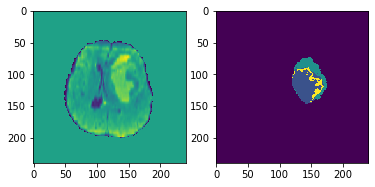

In [91]:
i = 18
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[i][0]) #, cmap='gray', vmin=0
axarr[1].imshow(y_train[i][0]) #, cmap='gray', vmin=0

##  Hyperparemeters

In [1]:
train_HGG_patients = 239
valid_HGG_patients = 20
slices_from_patient = 10
image_size = 240
channels = 4
learning_rate = 0.0001
# learning_rate = 5e-1
epochs = 25
batch_size = 10

## U-Net

In [94]:
model = model.UNet(channels, image_size)
adam_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, 
                                       beta_1=0.9, 
                                       beta_2=0.999)
sgd_optimizer = keras.optimizers.SGD(learning_rate=learning_rate, 
                                     momentum=0.5, 
                                     nesterov=True)
model.compile(optimizer=adam_optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"]
             )

Compiled with input shape (None, 4, 240, 240)


## Slice  augmentation

In [12]:
data_gen_args = dict(data_format="channels_first",
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     rotation_range=20,
                     horizontal_flip=True,
                     vertical_flip=True)
seed = 1

In [13]:
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [14]:
image_datagen.fit(train_data_x, augment=True, seed=seed)
mask_datagen.fit(train_data_y, augment=True, seed=seed)

In [15]:
x_train_datagen = image_datagen.flow(train_data_x, batch_size=batch_size, seed=seed)
y_train_datagen = mask_datagen.flow(train_data_y, batch_size=batch_size, seed=seed)

In [16]:
datagen = zip(x_train_datagen, y_train_datagen)

In [17]:
im = x_train_datagen.__getitem__(5)

mean -2.5219387e-07 min -2.255031 max 3.71634


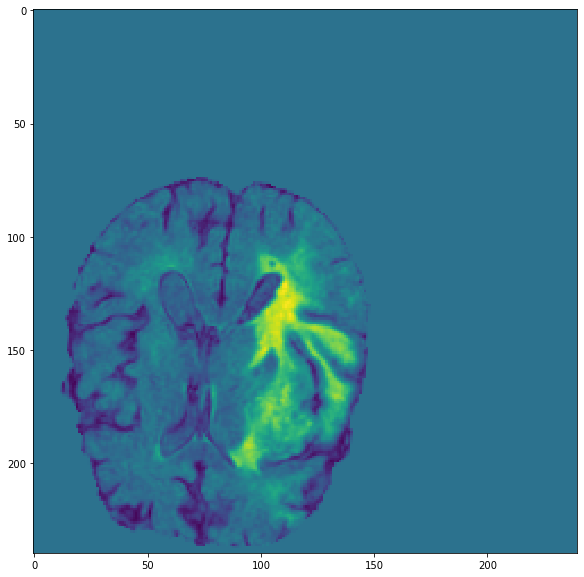

In [18]:
print("mean", im[0][0].mean(), "min", im[0][0].min(), "max", im[0][0].max() )

plt.figure(figsize = (10,10))
plt.imshow(im[0][0]) #, cmap='gray', vmin=0

In [19]:
imt = y_train_datagen.__getitem__(5)

mean 0.12729207 min 0.0 max 4.0


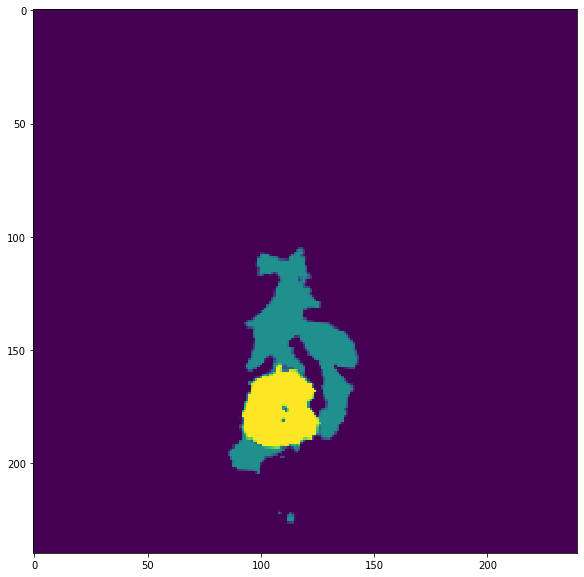

In [20]:
print("mean", imt[0][0].mean(), "min", imt[0][0].min(), "max", imt[0][0].max() )

plt.figure(figsize = (10,10))
plt.imshow(imt[0][0]) #, cmap='gray', vmin=0

## Callbacks

In [127]:
callbacks = [
    keras.callbacks.callbacks.TerminateOnNaN(),
    keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=0.0001, 
                                            patience=10, 
                                            verbose=1, 
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=True)
]

# Training

In [128]:
train_steps = train_HGG_patients
valid_steps = valid_HGG_patients

# hist = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
#                     epochs=epochs, shuffle=True, callbacks=callbacks)

hist = model.fit(x=train_data_x, y=train_data_y, validation_data=valid_data, 
                    epochs=epochs, shuffle=True, callbacks=callbacks, batch_size=batch_size)

# hist = model.fit_generator(datagen, validation_data=valid_data, steps_per_epoch=train_steps,
#                     epochs=epochs, shuffle=True, callbacks=callbacks)

# model.save("../models/2020040100.h5")

Train on 2390 samples, validate on 200 samples
Epoch 1/25


ResourceExhaustedError:  OOM when allocating tensor with shape[10,64,240,240] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node SquaredDifference_17 (defined at C:\Users\krcma\.conda\envs\tfgpu\lib\site-packages\keras\backend\tensorflow_backend.py:3020) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_318054]

Function call stack:
keras_scratch_graph


### Results

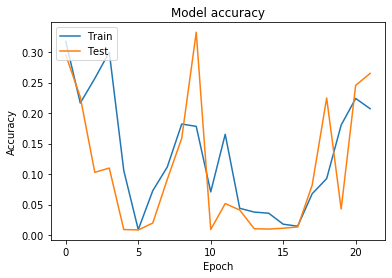

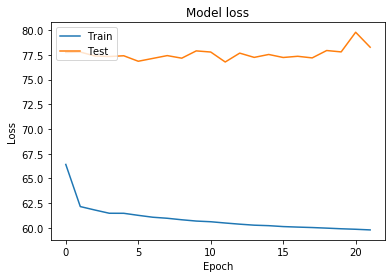

In [64]:
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
x, y = valid_gen.__getitem__(random.randint(0, 19))
pred = model.predict(x)

In [ ]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(x[0][0]) #, cmap='gray', vmin=0
axarr[1].imshow(y[0][0]) #, cmap='gray', vmin=0
axarr[2].imshow(pred[0][0]) #, cmap='gray', vmin=0